# WHACS Wave Hindcast Data Analysis

This notebook demonstrates how to access and analyze the WHACS (Wave Hindcast for Australian Climate and Sectors) wave hindcast data using the Oceanum Datamesh system.

## 1. Setup and Dependencies

In [ ]:
# Install required packages
!pip install oceanum xarray matplotlib cartopy


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# Import libraries
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from oceanum.datamesh import Query, Connector


## 2. Connect to WHACS Dataset

In [4]:
datamesh =Connector(service="https://datamesh-v1.oceanum.tech")
ds = datamesh.get_datasource("whacs_global")

You are using version 1.0.7 of oceanum_python which is the latest version available.
Using datamesh API version 1


## 3. Explore the Dataset

In [5]:
print(ds)
# Print dataset information
data_schema = ds.dataschema
print("Dataset dimensions:", data_schema.dims)
# Print available variables and their descriptions
print("\nDataset variables and their descriptions:")
for var in ds.variables:
    description = ds.variables[var]['attrs'].get('long_name', 'No description')
    print(f"{var}: {description}")



        WHACS Australia - Global grid [whacs_global]
            Extent: (0.0, -75.0, 360.0, 75.0)
            Timerange: 1979-01-01 00:00:00+00:00 to 2023-12-31 23:00:00+00:00
            0 attributes
            20 variables
        
Dataset dimensions: {'time': 394464, 'latitude': 1201, 'longitude': 2881}

Dataset variables and their descriptions:
dp: Peak wave direction
fp: Wave peak frequency
hs: Significant height of wind and swell waves
cge: Wave energy flux
dir: Mean wave direction
t01: Mean wave period T01
t02: Mean wave period (zero crossing) T02
phs0: Wave significant height partition 0
phs1: Wave significant height partition 1
phs2: Wave significant height partition 2
ptp0: Peak period partition 0
ptp1: Peak period partition 1
ptp2: Peak period partition 2
t0m1: Mean wave period T0m1
uwnd: Eastward wind
vwnd: Northward wind
pdir0: Mean wave direction partition 0
pdir1: Mean wave direction partition 1
pdir2: Mean wave direction partition 2
projected_coordinate_system: No de

## 4. Visualize Wave Height

In [6]:
def plot_wave_map(ds, time_idx=0, region=None):

    
    # Select data
    query = {"datasource": "whacs_australia",
        "variables": ["hs"],
        "timefilter": {
            "type": "range",
            "times": ["1979-02-11T15:00:00Z"]
        },
        "geofilter": {
            "type": "bbox",
            "geom": region if region else None
            }, 
        }
    ds_slice = datamesh.query(query)

    # Create a map
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Add map features
    ax.add_feature(cfeature.LAND, zorder=100)
    ax.add_feature(cfeature.COASTLINE, zorder=101)
    
    # Plot wave height
    ds_slice['hs'].plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap='viridis',
        add_colorbar=True
    )
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    plt.tight_layout()
    plt.show()

# # Plot global wave height
# plot_wave_map(ds, time_idx=0)

# Plot Tasman Sea region
tasman_sea = [150, -40, 180, -25]  # [lon_min, lat_min, lon_max, lat_max]
plot_wave_map(ds, time_idx=0, region=tasman_sea)

DatameshConnectError: Datamesh server error: {"detail":"Server error"}


## 5. Time Series Analysis

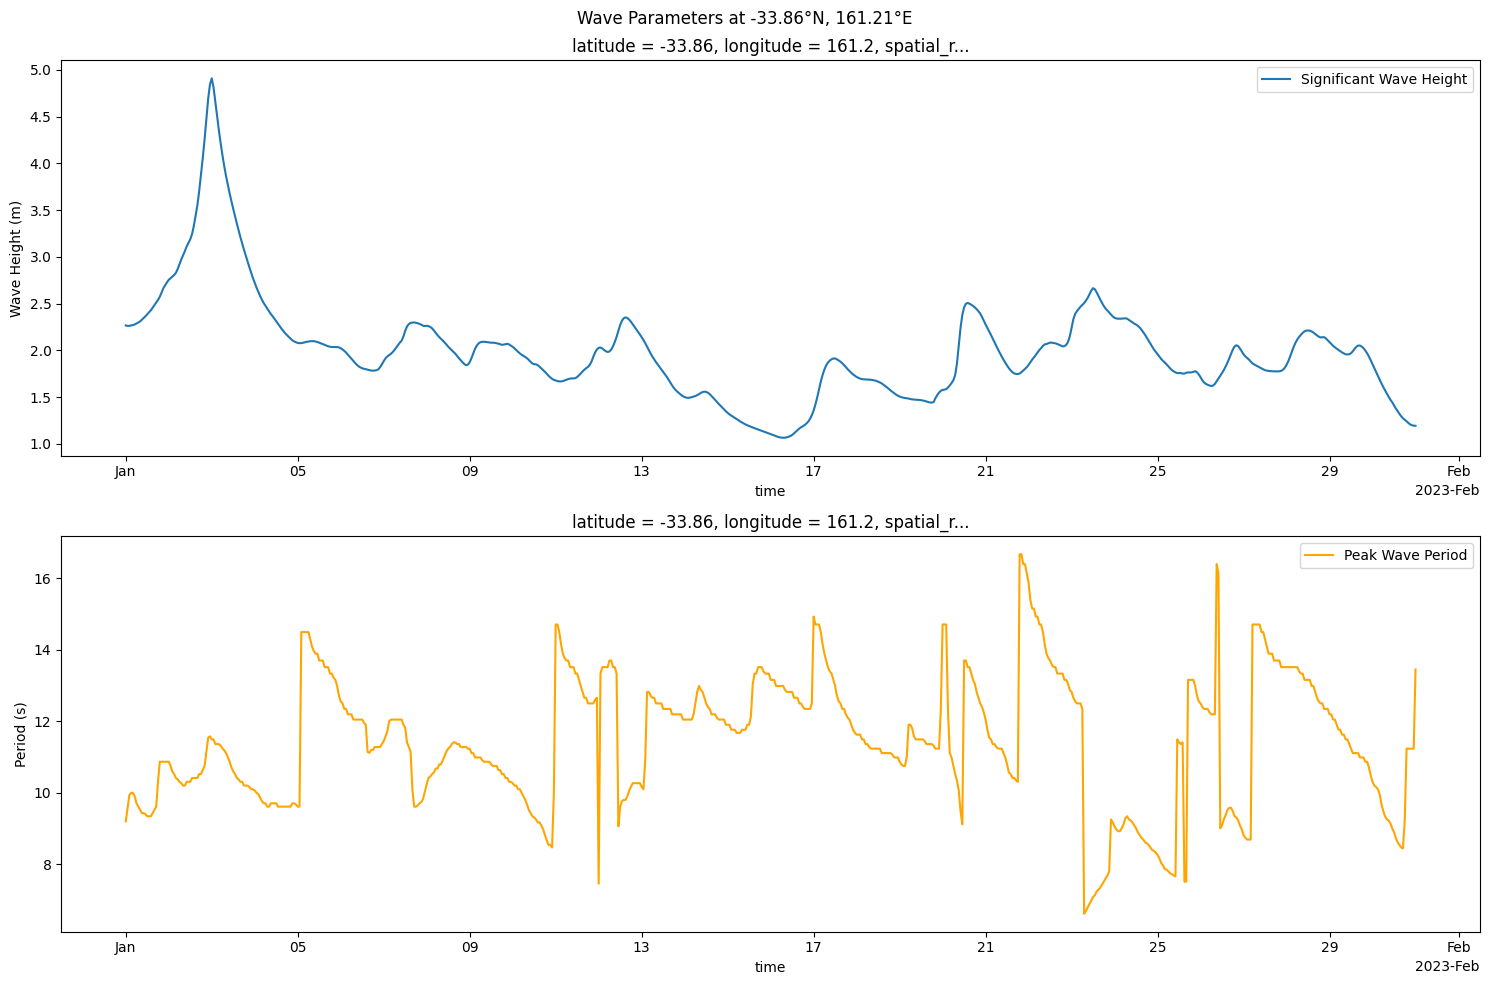

In [ ]:
def plot_time_series(ds, lat, lon, start_date=None, end_date=None):


    query = Query(**{"datasource": "whacs_australia",
            "variables": ["hs", "fp"],
            "timefilter": {
                "type": "range",
                "times": [start_date, end_date]
            },
            "geofilter": {
                "type": "feature",
                "geom": {
                    "type": "Feature",
                    "geometry": {
                        "type": "Point",
                        "coordinates": [
                                lon, lat 
                        ],
                    },
                }, 
            }
            })

    ds_point = datamesh.query(query)
    
    # Create plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot wave height
    ds_point['hs'].plot(ax=ax1, label='Significant Wave Height')
    ax1.set_ylabel('Wave Height (m)')
    ax1.legend()
    
    # Plot wave period
    (1/ds_point['fp']).plot(ax=ax2, color='orange', label='Peak Wave Period')
    ax2.set_ylabel('Period (s)')
    ax2.legend()
    
    plt.suptitle(f'Wave Parameters at {lat:.2f}°N, {lon:.2f}°E')
    plt.tight_layout()
    plt.show()

# Example: Plot time series for Sydney
plot_time_series(
    ds,
    lat=-33.86,  # Near Sydney
    lon=161.21,
    start_date='2023-01-01',  # One month of data
    end_date='2023-01-31'
)

## 6. Regional Statistics

In [ ]:
def regional_statistics(ds, region, time_idx=0):

    query = Query(**{"datasource": "whacs_australia",
            "variables": ["hs", "fp"],
            "timefilter": {
                "type": "range",
                "times": [start_date, end_date]
            },
            "geofilter": {
                "type": "bbox",
                "geom": region if region else None
                }, 
            }
            )
    ds_region = datamesh.query(query)
    
    # Calculate statistics
    stats = {}
    hs = ds_region['hs']
    stats['significant_wave_height'] = {
        'mean': float(hs.mean().values),
        'max': float(hs.max().values),
        'min': float(hs.min().values),
        'units': hs.attrs.get('units', 'm')
    }
    
    if 'fp' in ds_region:
        tp = 1/ds_region['fp']
        stats['peak_wave_period'] = {
            'mean': float(t0m1.mean().values),
            'max': float(t0m1.max().values),
            'min': float(t0m1.min().values),
            'units': 's'
        }
    
    # Display statistics
    print("\n--- Regional Statistics ---")
    for param, values in stats.items():
        print(f"\n{param.replace('_', ' ').title()}:")
        for stat, value in values.items():
            if stat != 'units':
                print(f"    {stat}: {value:.2f} {values['units']}")



# Example: Get statistics for the Tasman Sea region
tasman_sea = [150, 160, -40, -30]  # [lon_min, lon_max, lat_min, lat_max]
regional_statistics(ds, tasman_sea)